# Solving the Max-Clique Problem with LunaSolve

In this notebook, we'll explore how to tackle the **Max-Clique** problem using LunaSolve. First, we'll introduce and explain the Max-Clique problem through a straightforward example. Then, we'll walk step-by-step through modeling a real-world instance, optimizing the solution, and finally interpreting the results provided by LunaSolve.



## Table of Contents

1. [Introduction](#1)
2. [A Real World Example](#2)
3. [Solving the Max-Clique Problem with Luna](#3)



<a id="1"></a>
## 1. Introduction

## **Max-Clique** 
The Max-Clique problem is a combinatorial optimization problem in graph theory where the goal is to find the largest clique. A Clique is a subset of vertices in a graph where every pair of vertices is connected by an edge. Intuitively, it is about identifying the largest fully connected subgraph of the graph. 

However, the Max-Clique problem can also be expressed more precisely. Formally, a clique in an undirected graph $G = (V, E)$, with vertices $V$ and connecting edges $E$, is a subset of vertices $C \subseteq V$ such that for every pair of vertices $u, v \in C$, the edge $(u,v)$ is in $E$. Then the objective of the Max-Clique problem is to find a clique of maximum size in $G$.


<a id="2"></a>
## 2. A Real World Example

To better illustrate the Max-Clique problem consider the following example. Imagine you're planning a small board games night. You want to create an enjoyable and harmonious atmosphere with a group of friends. So you decide to invite a group of friends who all know and get along with one another, from your various social circles. However the games are more fun the more participate, so you choose from all of your friends. The challenge you are facing is to identify the largest group from your social circle, such that everyone gets along well.

You have the following information about your friends **Alice (A)**, **Bob (B)**, **Charlie (C)**, **David (D)**, **Emma (E)**, **Frank (F)**, **Grace (G)**, **Henry (H)**, **Irene (I)**, **Jade (J)**, and **Ken (K)**.

- A knows B, C, and D.  
- B knows A, C, and D.  
- C knows A, B, and D.  
- D knows A, B, C, and E.  
- E knows F, D, J, I and K.  
- F knows E.  
- G knows H and I.  
- H knows G and I.  
- I knows G and H.  
- J knows E and K.  
- K knows E and J.

The connections of these relationships can be represented as a network or a graph and will also improve the visualisation of our problem at hand.


<a id="3"></a>
## 3. Solving the Max-Clique problem with Luna

To follow along with the next steps, you'll need the following three libraries:
1. **luna_quantum** for modeling and solving our optimization problem,
2. **matplotlib** for visualizing the results, and
3. **networkx** for creating and displaying the graphs.

Run the cell below to install these libraries automatically if they aren't already installed.

In [ ]:
# Install the python packages that are needed for the notebook
%pip install --upgrade pip
%pip install luna_quantum --upgrade
%pip install matplotlib networkx

### 3.1 Setting Up the Luna Client

Now let's dive into solving the Max-Clique problem using LunaSolve.First, you'll instantiate a LunaSolve object and configure your credentials. The API key identifies your account and grants access to Luna's services. You can find your API key in your Aqarios account settings.

In [2]:
from luna_quantum import LunaSolve
import getpass
import os

if "LUNA_API_KEY" not in os.environ:
    # Prompt securely for the key if not already set
    os.environ["LUNA_API_KEY"] = getpass.getpass("Enter your Luna API key: ")

ls = LunaSolve()

In [ ]:
from luna_quantum import Logging
import logging

Logging.set_level(logging.WARNING)

If you haven't yet configured a QPU token for your account, or if you'd like to add a new one, you can do so using the `ls.qpu_token.create()` method. However, in this tutorial we will be using a classical solver from Dwave, which does not require one.

### 3.2 Creating a Max-Clique problem

To create a Max-Clique instance, any graph with vertices and edges is sufficient. In this notebook, we will create one representing the network of friendships among 11 of our friends. Each person is a node of the graph. Some pairs of our friends are also friends, and we express this attribute through an edge connecting the two nodes representing them. After defining the graph, we will visualize it for better comprehension.

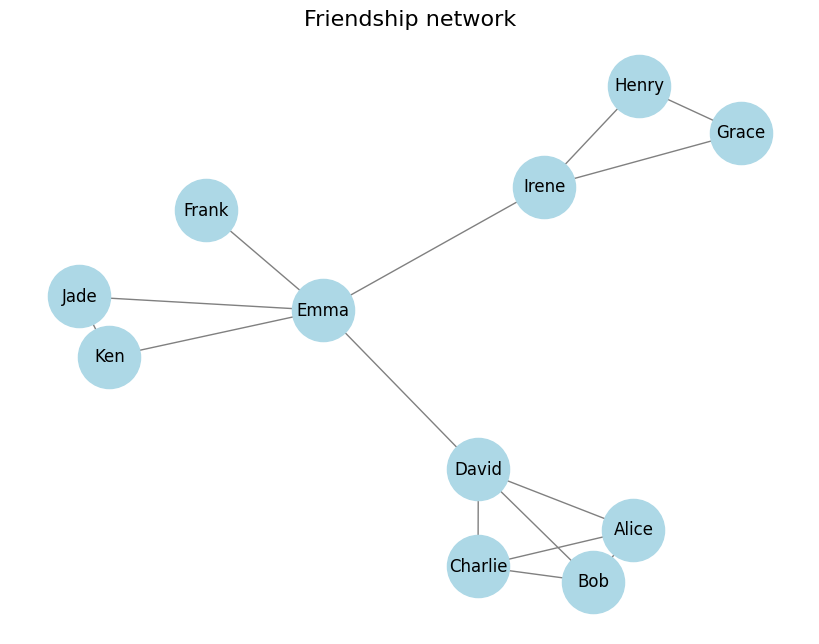

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph
max_clique_graph = nx.Graph()

# Add nodes to the graph (and represent our friends in the problem)
people = [
    "Alice", "Bob", "Charlie", "David", "Emma", "Frank",
    "Grace", "Henry", "Irene", "Jade", "Ken"
]
max_clique_graph.add_nodes_from(people)

# Add edges to the graph (and represent the relationships between our friends)
relationships = [
    ("Alice", "Bob"),
    ("Alice", "Charlie"),
    ("Alice", "David"),
    ("Bob", "Charlie"),
    ("Bob", "David"),
    ("Charlie", "David"),
    
    ("Emma", "David"),
    ("Emma", "Frank"),
    ("Emma", "Irene"),
    
    ("Grace", "Henry"),
    ("Henry", "Irene"),
    ("Irene", "Grace"),
    
    ("Emma", "Jade"),
    ("Jade", "Ken"),
    ("Ken", "Emma")
]
max_clique_graph.add_edges_from(relationships)

# Draw the graph using the matplotlib library
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(max_clique_graph)
nx.draw(
    max_clique_graph, pos, with_labels=True, node_size=2000, font_size=12, 
    node_color="lightblue", font_color="black", edge_color="gray"
)
plt.title("Friendship network", fontsize=16)
plt.show()


### 3.3 Defining a Max-Clique Object

The graph we created now represents a friendship network. To find the largest clique (fully connecting subgraph) using LunaSolve, we define the Max-Clique use case using Luna’s `MaxClique` class. This class converts the problem instance into an optimization problem, which Luna can then optimize.

When initializing the `MaxClique` object, ensure you pass the graph as a dictionary using NetworkX's `nx.to_dict_of_dicts()` method. Optionally, you can provide a descriptive `name` for your instance—if not specified, LunaSolve defaults it to `MCQ` for MaxClique.

In [5]:
# Import the MaxClique object from the luna sdk
from luna_quantum.solve.use_cases import MaxClique

# Create a MaxClique object, to use within the luna_sdk for optimisation
max_clique = MaxClique(graph=nx.to_dict_of_dicts(max_clique_graph))

### 3.4 Uploading the Use Case Model to Luna 

Now, let's upload our Max-Clique problem to Luna as an optimization task. We can use LunaSolve's `ls.model.create_from_use_case()` method and provide the use case object we just defined and assign a clear, identifiable `name` to the optimization.

In [6]:
# Initiliaze the optimization object using the created use case instance
model = ls.model.create_from_use_case(name="Max-Clique", use_case=max_clique)

### 3.5 Choose an Algorithm and Run It

The final step is to create a job request, sending our optimization task to the hardware provider to solve. To successfully create a job, we must first select an algorithm for the optimization from LunaSolve's collection, specify the algorithm's parameters and select a backend for the algorithm to run on.

In this instance, we solve the Max-Clique problem using simulated annealing (sa) and choose D-Wave (dwave) as the hardware provider. Simulated annealing has multiple parameters which can be adjusted to fine-tune the exact optimization. Here we are going to set the `num_reads` equal to 1000. This means that the annealing process is done 1000 times, returning 1000 sampled results.

Lastly, we exectue the job by calling the `algorithm.run()` method and passing the `model` together with a chosen `name`for the job for easy identification. 

In [7]:
from luna_quantum.solve.parameters.algorithms import SimulatedAnnealing
from luna_quantum.solve.parameters.backends import DWave

#Select the SimulatedAnnealingSolver algorithm.
algorithm = SimulatedAnnealing(
    backend=DWave(),
    num_reads=1000, 
)

# Execute an outbound solve request.
job = algorithm.run(model.id, name="Max-Clique with SA")

### 3.6 Retrieving the Solution

In step 3.4, we uploaded our problem, and in step 3.5, we sent a solution request to Luna. Luna automatically manages the subsequent background processes. This includes preparing the optimization problem, converting it into the correct format for the quantum hardware provider, submitting the problem to the quantum computer, and finally retrieving and translating the solution back into a user-friendly format.

Now let's discuss the final stages: retrieving the solution, converting it back to our original problem representation, and interpreting the results.

First, we'll use the `job.result()` method to fetch our results. The returned `Solution` object contains several attributes related to the optimization, including metadata such as the `runtime`, the `count` (how often each sample occurred), the `objective_value` and `raw_energies` of each sample. To learn more about the `Solution` Object visit Luna's thorough documentation.

In [ ]:
solution = job.result()

The `Solution` object returns the sampled solutions in the native optimization format of the provider's solver together with its metadata. To interpret the solutions quicker, LunaSolve provides automatic post-processing functions which decode the samples back into an intuitive and easy-to-read format as below.

You can use the `job.get_use_case_representation_result()` method to retrieve the decoded form of the solution. This returns the solution in a readable format, with a few key components:

- The `sense` attribute indicates whether our objective is to maximize or minimize the target function.
- The `result` is typically an iterable containing the `representation` (the solution itself) and the corresponding `obj_value` (objective value). While the objective value can be complex due to embedded constraint penalties, generally, smaller values signify better solutions for minimization problems and vice versa for maximization problems.
- The `description` helps clarify the format of the returned `representation`.

The `representation` for the case of the Max-Clique problem is straightforward. The solution is given back as a dictionary where each key is a member of the Maximal Clique. The value of each key is a dictionary of the neighbors of the key (node) itself.

****

### 🔍 Upcoming Feature: Use Case Representation Analysis

*Coming soon to the Luna SDK!*

We're introducing a powerful new capability: Use Case Representation Analysis. This feature will allow you to analyze and visualize how your use cases are interpreted across models and workflows—giving you deeper insight into solution quality, representation alignment, and more.

✨ **What to Expect**   
You'll soon be able to retrieve and examine the full use case representation for a given solve job:

In [ ]:
use_case_result = ls.solve_job.get_use_case_representation(job.id)
print(use_case_result)

Finally, if we wish to only see the best solution from all evaluated samples we can call the `job.get_use_case_representation_best_result()` method.

In [14]:
best_use_case_result = ls.solve_job.get_best_use_case_result(use_case_result)
print(best_use_case_result)

representation={'clique': {'Emma': {'Jade': {}}, 'Jade': {'Emma': {}}}, 'size': 2, 'is_valid': True} obj_value=-2.0


In order to better grasp the solution, we can visualise again our friendship connections using the graph we created, and colour all nodes which have a value of 0 red and all others that are 1, green.

In [15]:
# Colour the nodes based on the best result
colours = []
for node in max_clique_graph.nodes:
    if node in best_use_case_result["solution"]["clique"].keys():
        colours.append("green")
    else:
        colours.append("red")

# Draw the graph with new coloring
plt.figure(figsize=(8, 6))
nx.draw(max_clique_graph, pos, with_labels=True, node_color=colours, edge_color="gray", node_size=1000, font_size=12)
plt.title("Maximal Clique of the Friendship Network")
plt.show()

Congrats! You have now solved the Set Partitioning problem using the use case library of Luna! If you are interested in finding out more about the plethora of different use cases Luna provides, we encourage you to explore the use case library!